In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt

# Load train and test

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

In [4]:
_ = train.pop('id')

In [5]:
y = train.pop('Premium Amount')
X = train

In [6]:
data_processing_tr = X
data_processing_tr['y'] = y

# Data Cleaning

## Null Visualization

In [7]:
import missingno as msno
from matplotlib import pyplot as plt

In [8]:
X.columns[X.isnull().any()==False]

Index(['Gender', 'Education Level', 'Location', 'Policy Type',
       'Policy Start Date', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'y'],
      dtype='object')

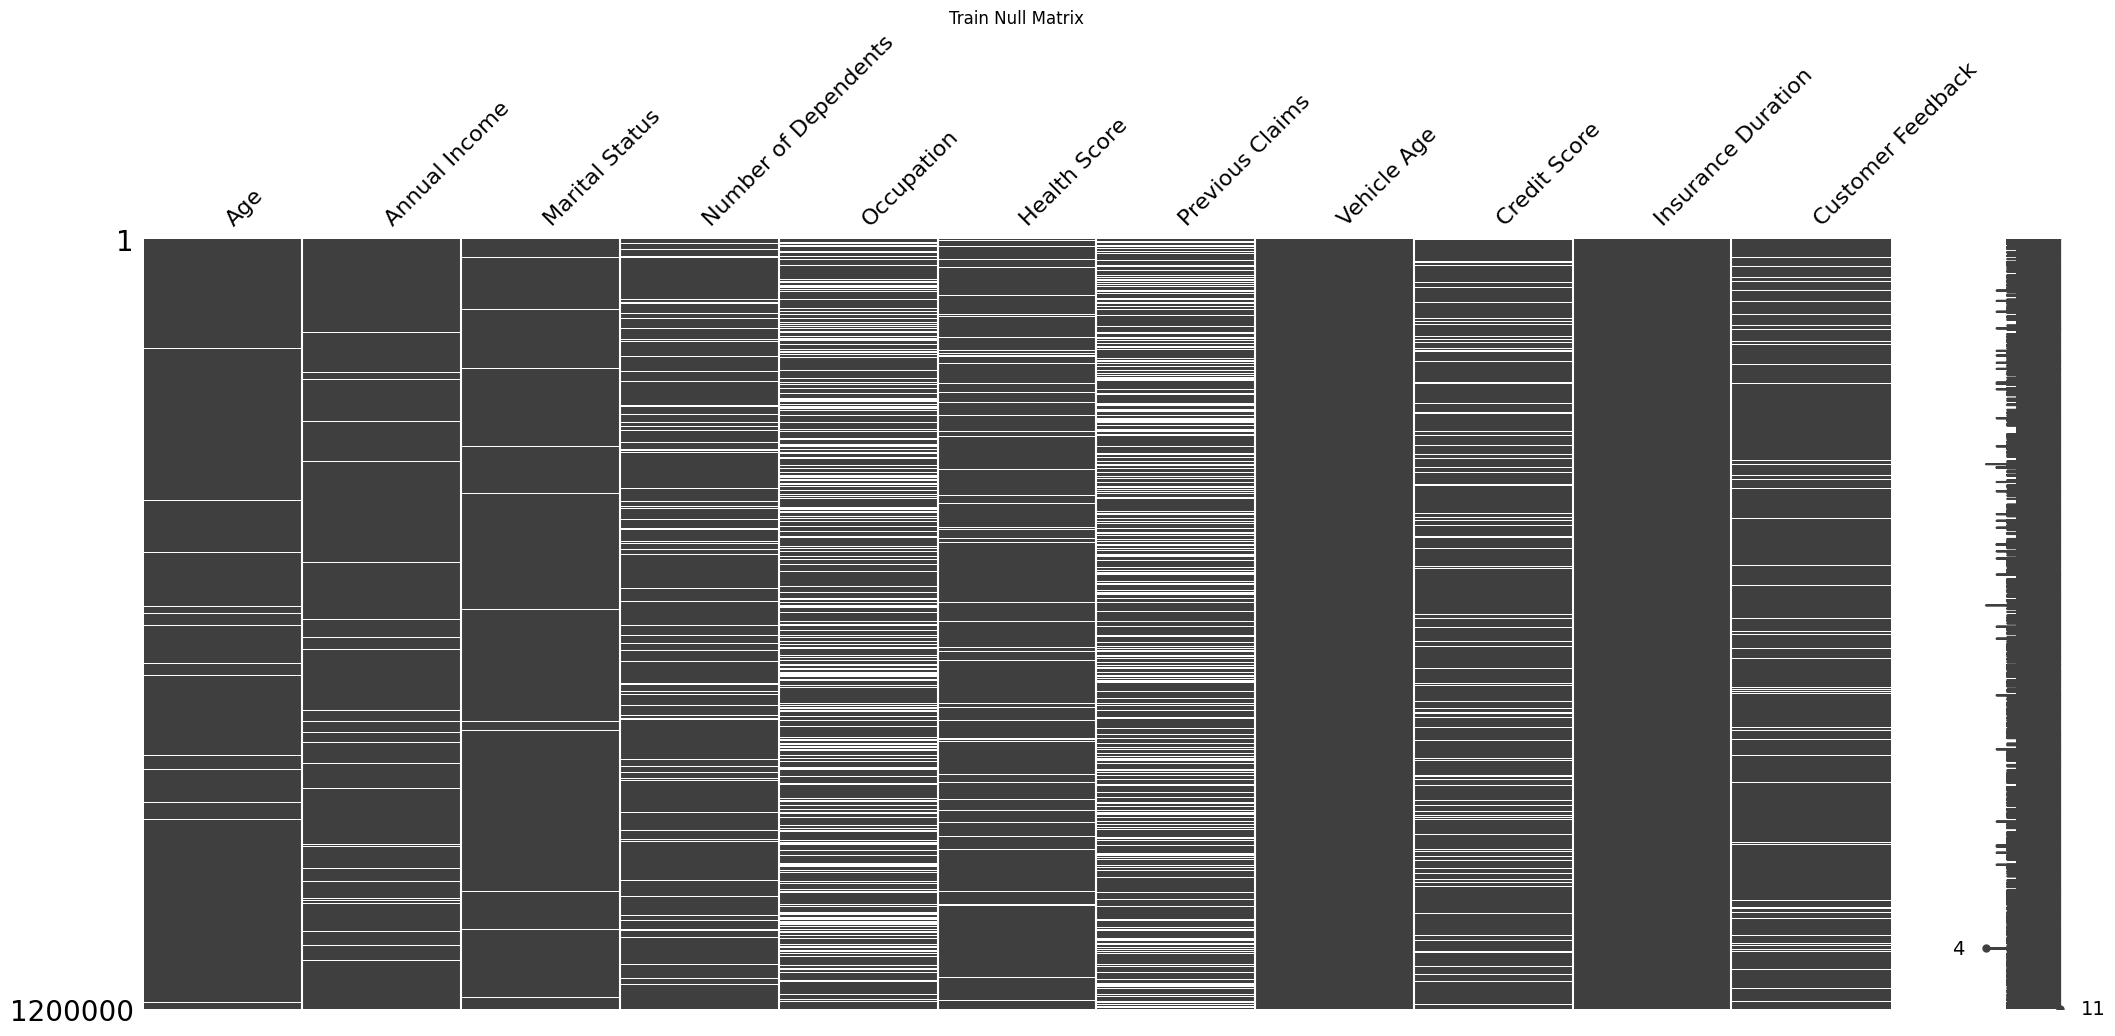

In [9]:
msno.matrix(X[X.columns[X.isnull().any()]])
_ = plt.title('Train Null Matrix')

In [10]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns

## Age

In [11]:
import math
X['Age'].describe()

count    1.181295e+06
mean     4.114556e+01
std      1.353995e+01
min      1.800000e+01
25%      3.000000e+01
50%      4.100000e+01
75%      5.300000e+01
max      6.400000e+01
Name: Age, dtype: float64

Let's divide the age to early adults: 
- Young adults: <=25
- Adults: 26-59
- Elders: 60+

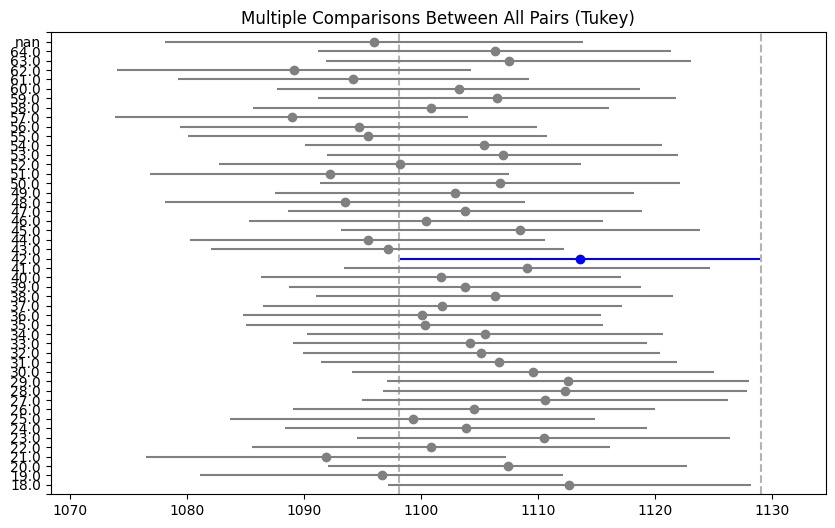

In [12]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

result = pairwise_tukeyhsd(endog=X['y'], groups=X['Age'])
result.plot_simultaneous(comparison_name=42)
plt.show()

We can now be sure that there's no difference in distributions of y in terms of age groups.

In [13]:
X['Age'].fillna(X['Age'].mode()[0], inplace=True)
test['Age'].fillna(test['Age'].mode()[0], inplace=True)

## Annual Income

In [14]:
train_income_null = X.loc[X['Annual Income'].isnull()]
train_income_filled = X.loc[~X['Annual Income'].isnull()]
_ = train_income_null.pop('Annual Income')

Let's divide annual income into several groups: low, mid and high.
- Low income: in the lower quantile
- High income: in the upper quantile
- Mid income: in between 

In [15]:
quantile = train_income_filled['Annual Income'].quantile([0.25])
lower = quantile[0.25]
train_income_filled['Low Income'] = train_income_filled['Annual Income']<lower

C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\4210819176.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_income_filled['Low Income'] = train_income_filled['Annual Income']<lower


In [16]:
test_income_null = test.loc[test['Annual Income'].isnull()]
test_income_filled = test.loc[~test['Annual Income'].isnull()]
_ = test_income_null.pop('Annual Income')

quantile = test_income_filled['Annual Income'].quantile([0.25])
lower = quantile[0.25]
test_income_filled['Low Income'] = test_income_filled['Annual Income']<lower

C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\1144865001.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_income_filled['Low Income'] = test_income_filled['Annual Income']<lower


## Number of Dependants

In [17]:
train_income_filled['Number of Dependents'].fillna(5, inplace=True)
train_income_null['Number of Dependents'].fillna(5, inplace=True)
test_income_filled['Number of Dependents'].fillna(5, inplace=True)
test_income_null['Number of Dependents'].fillna(5, inplace=True)

C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\2279663032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_income_filled['Number of Dependents'].fillna(5, inplace=True)
C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\2279663032.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_income_null['Number of Dependents'].fillna(5, inplace=True)
C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\2279663032.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

## Marital Status

In [18]:
train_income_filled['Marital Status'].fillna('Other', inplace=True)
train_income_null['Marital Status'].fillna('Other', inplace=True)
test_income_filled['Marital Status'].fillna('Other', inplace=True)
test_income_null['Marital Status'].fillna('Other', inplace=True)

C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\2720199433.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_income_filled['Marital Status'].fillna('Other', inplace=True)
C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\2720199433.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_income_null['Marital Status'].fillna('Other', inplace=True)
C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\2720199433.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

## Occupation

In [19]:
train_income_filled['Occupation'].fillna('Other', inplace=True)
train_income_null['Occupation'].fillna('Other', inplace=True)
test_income_filled['Occupation'].fillna('Other', inplace=True)
test_income_null['Occupation'].fillna('Other', inplace=True)

C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\504269469.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_income_filled['Occupation'].fillna('Other', inplace=True)
C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\504269469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_income_null['Occupation'].fillna('Other', inplace=True)
C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\504269469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

## Health Score

In [20]:
tr_i = train_income_filled.loc[~train_income_filled['Health Score'].isnull(), 'Health Score']
tr_n = train_income_null.loc[~train_income_null['Health Score'].isnull(), 'Health Score']
te_i = test_income_filled.loc[~test_income_filled['Health Score'].isnull(), 'Health Score']
te_n = test_income_null.loc[~test_income_null['Health Score'].isnull(), 'Health Score']
train_income_filled['Health Score'] = train_income_filled['Health Score'].apply(lambda x: x if not np.isnan(x) 
                                                                              else np.random.choice(tr_i))
train_income_null['Health Score'] = train_income_null['Health Score'].apply(lambda x: x if not np.isnan(x) 
                                                                              else np.random.choice(tr_n))
test_income_filled['Health Score'] = test_income_filled['Health Score'].apply(lambda x: x if not np.isnan(x)
                                                                                          else np.random.choice(te_i))
test_income_null['Health Score'] = test_income_null['Health Score'].apply(lambda x: x if not np.isnan(x)
                                                                                          else np.random.choice(te_n))                                                                                                                  
                                                                                

C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\1238717199.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_income_filled['Health Score'] = train_income_filled['Health Score'].apply(lambda x: x if not np.isnan(x)
C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\1238717199.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_income_null['Health Score'] = train_income_null['Health Score'].apply(lambda x: x if not np.isnan(x)
C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\1238717199.py:9

## Previous Claims

In [21]:
train_income_filled['Previous Claims'].fillna(0, inplace=True)
train_income_null['Previous Claims'].fillna(0, inplace=True)
test_income_null['Previous Claims'].fillna(0, inplace=True)
test_income_filled['Previous Claims'].fillna(0, inplace=True)

C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\3895633175.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_income_filled['Previous Claims'].fillna(0, inplace=True)
C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\3895633175.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_income_null['Previous Claims'].fillna(0, inplace=True)
C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\3895633175.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

## Credit Score 

In [22]:
tr_i = train_income_filled.loc[~train_income_filled['Credit Score'].isnull(), 'Credit Score']
tr_n = train_income_null.loc[~train_income_null['Credit Score'].isnull(), 'Credit Score']
te_i = test_income_filled.loc[~test_income_filled['Credit Score'].isnull(), 'Credit Score']
te_n = test_income_null.loc[~test_income_null['Credit Score'].isnull(), 'Credit Score']
train_income_filled['Credit Score'] = train_income_filled['Credit Score'].apply(lambda x: x if not np.isnan(x) 
                                                                              else np.random.choice(tr_i))
train_income_null['Credit Score'] = train_income_null['Credit Score'].apply(lambda x: x if not np.isnan(x) 
                                                                              else np.random.choice(tr_n))
test_income_filled['Credit Score'] = test_income_filled['Credit Score'].apply(lambda x: x if not np.isnan(x)
                                                                                          else np.random.choice(te_i))
test_income_null['Credit Score'] = test_income_null['Credit Score'].apply(lambda x: x if not np.isnan(x)
                                                                                          else np.random.choice(te_n))                                                                                                                  
                                                                                

C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\1168030135.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_income_filled['Credit Score'] = train_income_filled['Credit Score'].apply(lambda x: x if not np.isnan(x)
C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\1168030135.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_income_null['Credit Score'] = train_income_null['Credit Score'].apply(lambda x: x if not np.isnan(x)
C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\1168030135.py:9

## Insurance Duration

In [23]:
X['Insurance Duration'].unique()

array([ 5.,  2.,  3.,  1.,  4.,  6.,  8.,  9.,  7., nan])

In [24]:
# According to the discussion post here: https://www.kaggle.com/competitions/playground-series-s4e12/discussion/552165
# This column isn't null by random so we have to keep it
train_income_filled['Insurance Duration'].fillna(0, inplace=True)
train_income_null['Insurance Duration'].fillna(0, inplace=True)
test_income_filled['Insurance Duration'].fillna(0, inplace=True)
test_income_null['Insurance Duration'].fillna(0, inplace=True)

C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\2329970073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_income_filled['Insurance Duration'].fillna(0, inplace=True)
C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\2329970073.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_income_null['Insurance Duration'].fillna(0, inplace=True)
C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\2329970073.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

## Vehicle Age

In [25]:
train_income_filled['Vehicle Age'].fillna(0, inplace=True)
train_income_null['Vehicle Age'].fillna(0, inplace=True)
test_income_filled['Vehicle Age'].fillna(0, inplace=True)
test_income_null['Vehicle Age'].fillna(0, inplace=True)

C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\316782706.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_income_filled['Vehicle Age'].fillna(0, inplace=True)
C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\316782706.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_income_null['Vehicle Age'].fillna(0, inplace=True)
C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\316782706.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

## Customer Feedback

In [26]:
train_income_filled['Customer Feedback'].fillna('Other', inplace=True)
train_income_null['Customer Feedback'].fillna('Other', inplace=True)
test_income_filled['Customer Feedback'].fillna('Other', inplace=True)
test_income_null['Customer Feedback'].fillna('Other', inplace=True)

C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\3074486526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_income_filled['Customer Feedback'].fillna('Other', inplace=True)
C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\3074486526.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_income_null['Customer Feedback'].fillna('Other', inplace=True)
C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\3074486526.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

## Policy Start Date

I didn't think about looking into this column until I looked deeper into the data

In [27]:
train_income_filled['Policy Start Date'] = pd.to_datetime(train_income_filled['Policy Start Date'])
train_income_null['Policy Start Date'] = pd.to_datetime(train_income_null['Policy Start Date'])
test_income_filled['Policy Start Date'] = pd.to_datetime(test_income_filled['Policy Start Date'])
test_income_null['Policy Start Date'] = pd.to_datetime(test_income_null['Policy Start Date'])

C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\343966571.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_income_filled['Policy Start Date'] = pd.to_datetime(train_income_filled['Policy Start Date'])
C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\343966571.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_income_null['Policy Start Date'] = pd.to_datetime(train_income_null['Policy Start Date'])
C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\343966571.py:3: SettingWithCopyWarning:

In [28]:
train_income_filled['Policy Start Year'] = train_income_filled['Policy Start Date'].apply(lambda x: x.year)
test_income_filled['Policy Start Year'] = test_income_filled['Policy Start Date'].apply(lambda x: x.year)
train_income_null['Policy Start Year'] = train_income_null['Policy Start Date'].apply(lambda x: x.year)
test_income_null['Policy Start Year'] = test_income_null['Policy Start Date'].apply(lambda x: x.year)

C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\335354772.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_income_filled['Policy Start Year'] = train_income_filled['Policy Start Date'].apply(lambda x: x.year)
C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\335354772.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_income_filled['Policy Start Year'] = test_income_filled['Policy Start Date'].apply(lambda x: x.year)
C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\335354772.py:3: Setti

In [29]:
train_income_filled['Month'] = train_income_filled['Policy Start Date'].apply(lambda x: x.month)
test_income_filled['Month'] = test_income_filled['Policy Start Date'].apply(lambda x: x.month)
train_income_null['Month'] = train_income_null['Policy Start Date'].apply(lambda x: x.month)
test_income_null['Month'] = test_income_null['Policy Start Date'].apply(lambda x: x.month)

C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\3109867632.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_income_filled['Month'] = train_income_filled['Policy Start Date'].apply(lambda x: x.month)
C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\3109867632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_income_filled['Month'] = test_income_filled['Policy Start Date'].apply(lambda x: x.month)
C:\Users\Huawei\AppData\Local\Temp\ipykernel_44972\3109867632.py:3: SettingWithCopyWarning: 

In [30]:
train_income_filled = train_income_filled.drop(['Policy Start Date'], axis=1)
train_income_null = train_income_null.drop(['Policy Start Date'], axis=1)
test_income_null = test_income_null.drop(['Policy Start Date'], axis=1)
test_income_filled = test_income_filled.drop(['Policy Start Date'], axis=1)

# `get_dummies`: final data processing

In [31]:
y_income = train_income_filled.pop('y')
y_wo_income = train_income_null.pop('y')

In [32]:
train_income_filled.isnull().any()

Age                     False
Gender                  False
Annual Income           False
Marital Status          False
Number of Dependents    False
Education Level         False
Occupation              False
Health Score            False
Location                False
Policy Type             False
Previous Claims         False
Vehicle Age             False
Credit Score            False
Insurance Duration      False
Customer Feedback       False
Smoking Status          False
Exercise Frequency      False
Property Type           False
Low Income              False
Policy Start Year       False
Month                   False
dtype: bool

In [33]:
train_income_filled = pd.get_dummies(train_income_filled)
train_income_null = pd.get_dummies(train_income_null)

In [62]:
test_income_filled = pd.get_dummies(test_income_filled)
test_income_null = pd.get_dummies(test_income_null)

In [126]:
from sklearn.preprocessing import minmax_scale
train_income_filled_scaled = minmax_scale(train_income_filled)
train_income_null_scaled = minmax_scale(train_income_null)

In [63]:
test_income_filled_scaled = minmax_scale(test_income_filled)
test_income_null_scaled = minmax_scale(test_income_null)

In [35]:
from sklearn.feature_selection import f_classif

_, p_val = f_classif(train_income_filled_scaled, y_income)
p_val>0.05

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [36]:
_, p_val = f_classif(train_income_null_scaled, y_wo_income)
p_val>0.05

array([False, False, False, False,  True, False,  True, False, False,
        True,  True,  True,  True, False, False,  True, False, False,
       False,  True, False, False,  True, False, False, False, False,
        True,  True, False,  True, False, False,  True,  True, False,
       False,  True, False,  True,  True,  True])

<Axes: >

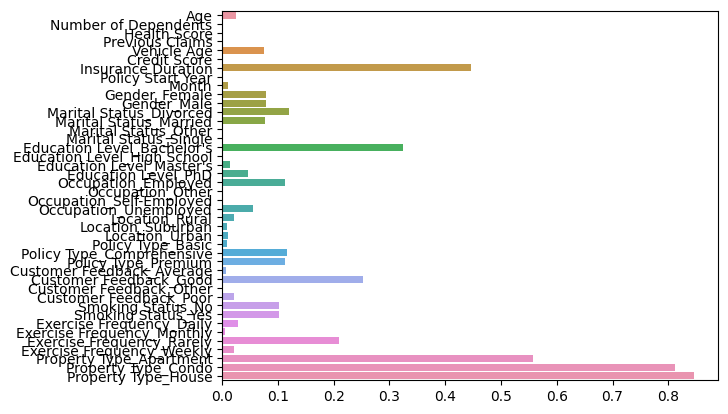

In [37]:
sns.barplot(x=p_val, y=train_income_null.columns)

We can see that we only need to perform feature selection on `train_income_null`

# Finally----The Training Starts!

## XGBoost for un-null income

In [38]:
from xgboost import XGBRegressor
import optuna
from optuna import visualization as op_viz 
from optuna import trial
from sklearn.model_selection import cross_val_score
from optuna.pruners import MedianPruner

C:\Users\Huawei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
def objective(trial):
    params = {
        'verbosity':0,
        'eta': trial.suggest_float('eta', 0.01, 0.2),
        'gamma': trial.suggest_float('gamma', 3, 20),
        'max_depth': trial.suggest_int('max_depth', 20, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 100, 1500),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.95, 1),
        'lambda': trial.suggest_float('lambda', 10, 1000),
        'alpha': trial.suggest_float('alpha', 0, 500),
    }

    model = XGBRegressor(**params)
    log_y = np.log(y_income)
    scores = cross_val_score(model, train_income_filled_scaled, log_y, scoring='neg_mean_squared_error', cv=10)
    scores = -scores
    scores = np.sqrt(scores)
    return np.mean(scores)

In [43]:
pruner = MedianPruner()
study = optuna.create_study(direction='minimize', pruner=pruner) 
study.optimize(objective, n_trials=300)

[I 2024-12-27 17:38:58,994] A new study created in memory with name: no-name-dfe8e287-4e03-40cb-a00f-073f43ac6536
[I 2024-12-27 17:40:24,709] Trial 0 finished with value: 1.0574078840120396 and parameters: {'eta': 0.09196478960499538, 'gamma': 14.505843792917863, 'max_depth': 84, 'min_child_weight': 911, 'subsample': 0.563438497117114, 'colsample_bytree': 0.9818596323338549, 'lambda': 769.0895173755791, 'alpha': 226.2990526139732}. Best is trial 0 with value: 1.0574078840120396.
[I 2024-12-27 17:41:43,235] Trial 1 finished with value: 1.057329189993192 and parameters: {'eta': 0.17002365831459776, 'gamma': 19.10801202051503, 'max_depth': 37, 'min_child_weight': 1164, 'subsample': 0.5019248130854519, 'colsample_bytree': 0.9712416621373104, 'lambda': 590.1520875036482, 'alpha': 10.325779673969803}. Best is trial 1 with value: 1.057329189993192.
[I 2024-12-27 17:43:12,970] Trial 2 finished with value: 1.0572838781041156 and parameters: {'eta': 0.11300708606100598, 'gamma': 7.04651995082904

In [44]:
op_viz.plot_optimization_history(study)

In [45]:
op_viz.plot_slice(study)

In [46]:
op_viz.plot_param_importances(study)

## XGBoost for Null Income

In [52]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
def null_objective(trial):
    params = {
        'verbosity':0,
        'eta': trial.suggest_float('eta', 0.03, 0.06),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'max_depth': trial.suggest_int('max_depth', 10, 300),
        'min_child_weight': trial.suggest_int('min_child_weight', 100, 300),
        'subsample': trial.suggest_float('subsample', 0.95, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.95, 1),
        'lambda': trial.suggest_float('lambda', 300, 700),
        'alpha': trial.suggest_float('alpha', 0, 5),
    }
   
    k_best = trial.suggest_int('k', 10, 20)
    pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif, k = k_best)),
    ('model', XGBRegressor(**params))
    ])
    
    model = XGBRegressor(**params)
    log_y = np.log(y_wo_income)
    scores = cross_val_score(pipeline, train_income_null_scaled, log_y, scoring='neg_mean_squared_error', cv=10)
    scores = -scores
    scores = np.sqrt(scores)
    return np.mean(scores)

In [53]:
pruner = MedianPruner()
null_study = optuna.create_study(direction='minimize', pruner=pruner) 
null_study.optimize(null_objective, n_trials=1000)

[I 2024-12-28 20:08:46,301] A new study created in memory with name: no-name-08edf651-936e-4dc1-900e-7450e61a34f5
[I 2024-12-28 20:08:57,694] Trial 0 finished with value: 1.1510957765022858 and parameters: {'eta': 0.0316753799154505, 'gamma': 1.407408293202856, 'max_depth': 211, 'min_child_weight': 232, 'subsample': 0.9575061879048855, 'colsample_bytree': 0.9777747641380411, 'lambda': 594.5462276891069, 'alpha': 4.383296286273683, 'k': 10}. Best is trial 0 with value: 1.1510957765022858.
[I 2024-12-28 20:09:12,401] Trial 1 finished with value: 1.1480810272809139 and parameters: {'eta': 0.042685744573295645, 'gamma': 0.2219574044297018, 'max_depth': 153, 'min_child_weight': 187, 'subsample': 0.9598829580633973, 'colsample_bytree': 0.96155794529106, 'lambda': 697.1809896169486, 'alpha': 0.16855846202788016, 'k': 17}. Best is trial 1 with value: 1.1480810272809139.
[I 2024-12-28 20:09:30,592] Trial 2 finished with value: 1.148299146530683 and parameters: {'eta': 0.04163284237828839, 'gamm

In [55]:
null_study.optimize(null_objective, n_trials=1000)

[I 2024-12-28 23:29:28,802] Trial 1000 finished with value: 1.147271086334034 and parameters: {'eta': 0.05470949145595036, 'gamma': 2.448998500347404, 'max_depth': 79, 'min_child_weight': 111, 'subsample': 0.9914795774420855, 'colsample_bytree': 0.9541863317659013, 'lambda': 464.03893079770586, 'alpha': 2.7932759898967108, 'k': 19}. Best is trial 872 with value: 1.147003991193455.
[I 2024-12-28 23:29:39,786] Trial 1001 finished with value: 1.1473111013706956 and parameters: {'eta': 0.05399461675066551, 'gamma': 2.2679928557212374, 'max_depth': 231, 'min_child_weight': 101, 'subsample': 0.9891618954854492, 'colsample_bytree': 0.9562567702178095, 'lambda': 489.09685906707523, 'alpha': 2.5700742897619695, 'k': 19}. Best is trial 872 with value: 1.147003991193455.
[I 2024-12-28 23:29:50,034] Trial 1002 finished with value: 1.147305840601799 and parameters: {'eta': 0.05487988412634511, 'gamma': 2.830157999239691, 'max_depth': 10, 'min_child_weight': 110, 'subsample': 0.9933279080983235, 'co

In [56]:
op_viz.plot_optimization_history(null_study)

In [57]:
op_viz.plot_slice(null_study)

In [58]:
op_viz.plot_param_importances(null_study)

In [61]:
(1.0565195314526108*train_income_filled.shape[0]+1.1470000555581554*train_income_null.shape[0])/X.shape[0]

1.0599087056842944

In [127]:
model1 = XGBRegressor(**study.best_params)
model1.fit(train_income_filled_scaled, np.log(y_income))

XGBRegressor(alpha=44.93721454148807, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9894957677887362, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.08926974887621053, eval_metric=None, feature_types=None,
             gamma=5.075539129682223, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=266.4355731885085,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=66,
             max_leaves=None, min_child_weight=100, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None, ...)

In [128]:
model1.score(train_income_filled_scaled, np.log(y_income))

0.06576298761509891

In [79]:
len(train_income_filled.columns)

44

In [78]:
len(test_income_filled.columns)

45

In [84]:
id_filled = test_income_filled.pop('id')

KeyError: 'id'

In [85]:
id_null = test_income_null.pop('id')


KeyError: 'id'

In [87]:
test_income_filled_scaled = minmax_scale(test_income_filled)
test_income_null_scaled = minmax_scale(test_income_null)

In [129]:
y_d = model1.predict(test_income_filled_scaled)

In [131]:
y_d = np.exp(y_d)

In [132]:
y_d

array([830.28723, 778.7942 , 796.0677 , ..., 805.6788 , 814.69366,
       810.3717 ], dtype=float32)

In [133]:
k = null_study.best_params.pop('k')

In [134]:
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif, k = k)),
    ('model', XGBRegressor(**null_study.best_params))
    ])

In [135]:
select = SelectKBest(score_func=f_classif, k = k, )

In [136]:
train_income_null = select.fit_transform(train_income_null, y_wo_income)


In [137]:
train_income_null_scaled = minmax_scale(train_income_null)

In [138]:
test_income_null = select.transform(test_income_null)
test_income_null_scaled = minmax_scale(test_income_null)

In [139]:
train_income_null.shape

(44949, 19)

In [140]:
params = null_study.best_params
_ = params.pop('k')

In [141]:
train_income_null_scaled.shape

(44949, 19)

In [142]:
model2 = XGBRegressor(**params)
model2.fit(train_income_null_scaled, np.log(y_wo_income))

XGBRegressor(alpha=2.8978509025181576, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9550008975026957, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.056917904430285264, eval_metric=None, feature_types=None,
             gamma=2.02753159700939, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=467.7042956882189,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=121, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None, ...)

In [143]:
y_n = model2.predict(test_income_null_scaled)

In [144]:
y_n = np.exp(y_n)

In [145]:
result_filled = pd.DataFrame({'Premium Amount': y_d}, index=id_filled)
result_null = pd.DataFrame({'Premium Amount': y_n}, index = id_null)

result = pd.concat([result_filled, result_null], sort=True)

In [146]:
result.head()

,Premium Amount
id,
1200000,830.287231
1200001,778.794189
1200002,796.067688
1200003,796.517578
1200004,754.112549


In [147]:
result.to_csv('result.csv', index_label='id')